In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.task_switching.hooks as hooks
from multitask.models.task_switching.models import get_task_model
from multitask.representations import get_mean_activations, calculate_sm, plot_sm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figure02a_sm_task_switching.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')
path_pickle = os.path.join('pickle', 'sm_task_switching.pickle')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_18_47)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


## Plot All RDMs

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

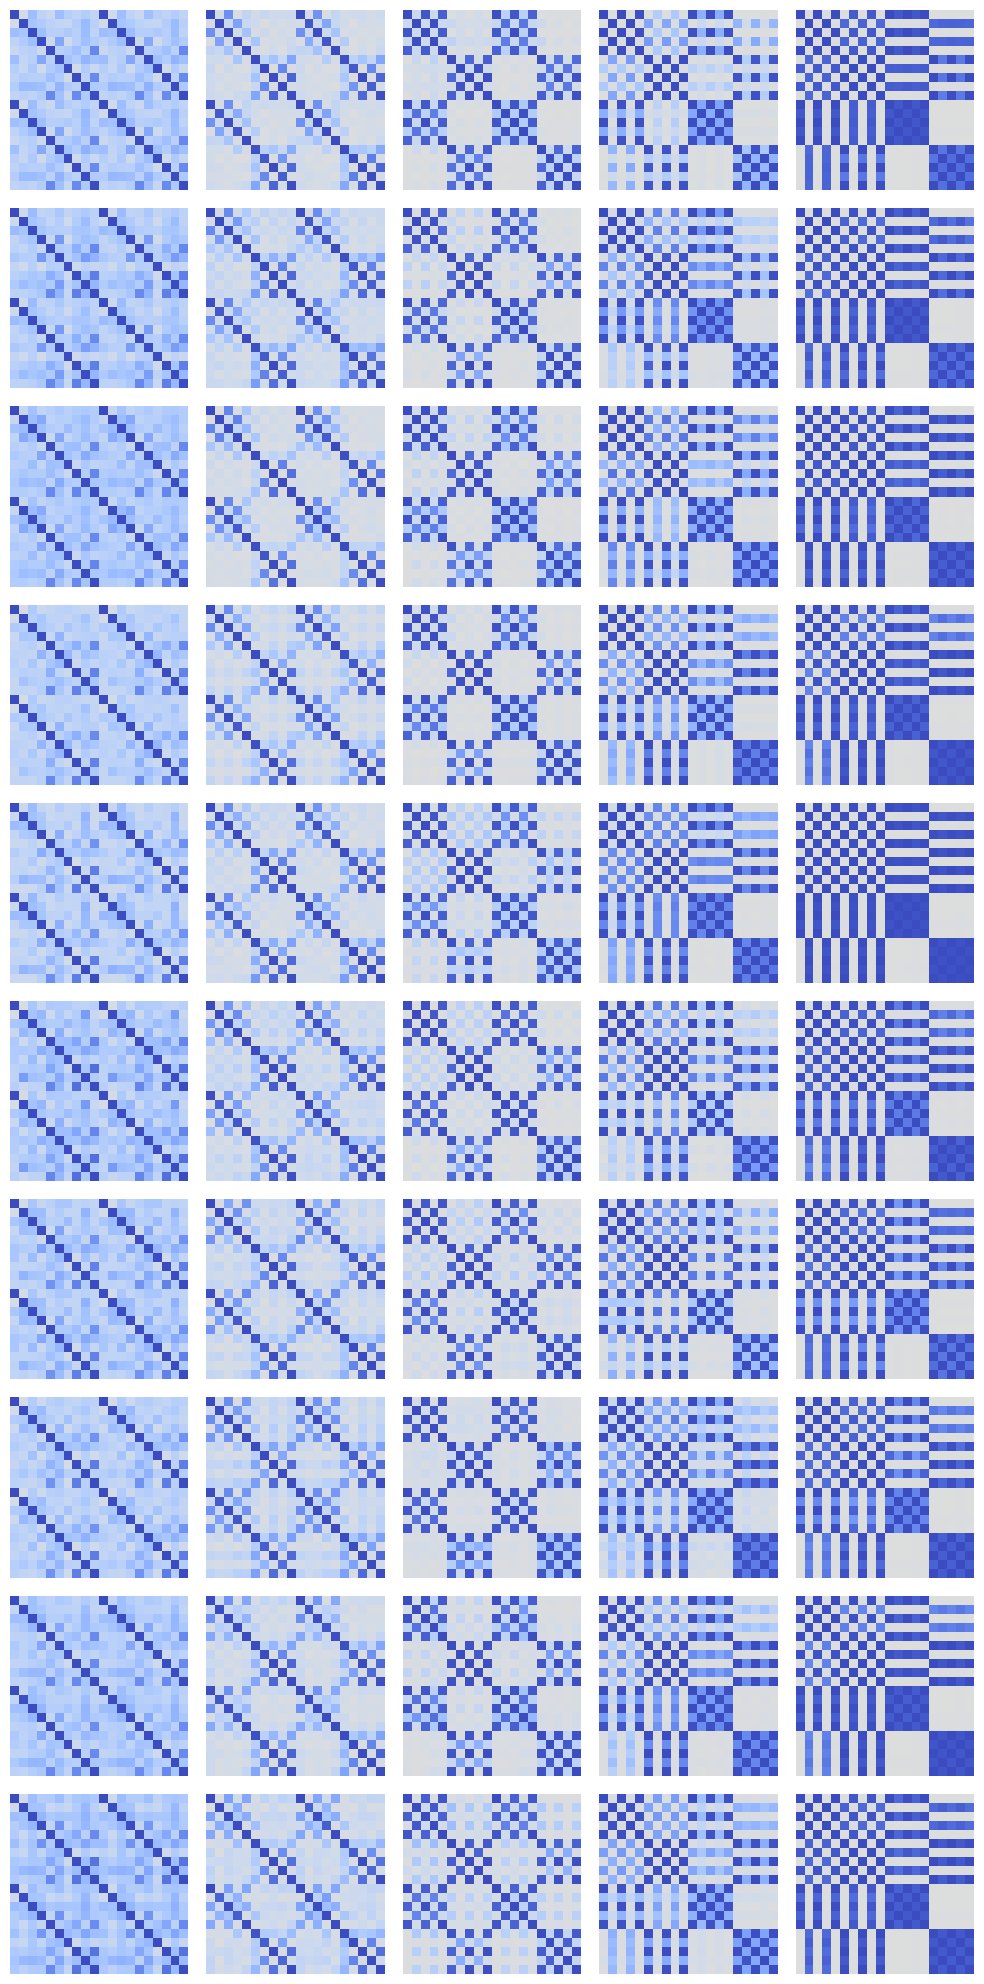

In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
list_sm = []

fig, ax = plt.subplots(num_runs, num_layers, figsize=(2 * num_layers, 2 * num_runs))

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)

    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    sm_dict = calculate_sm(mean_activations,
                             tasks_names=tasks_names)
    
    list_sm.append(sm_dict)

    plot_sm(ax[i_seed], sm_dict, num_hidden)

fig.tight_layout()
plt.show()

In [10]:
parent_pickle = os.path.dirname(path_pickle)

if not os.path.exists(parent_pickle):
    os.makedirs(parent_pickle)

with open(path_pickle, 'wb') as f:
    pickle.dump(list_sm, f, protocol=pickle.HIGHEST_PROTOCOL)

## Average RDM

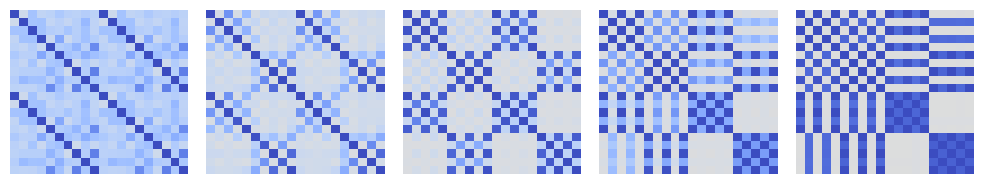

In [11]:
mean_sm = {}

for layer in range(num_layers):
    mean_sm[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_sm:
        mean_sm[layer+1] += rdm[layer+1]
    mean_sm[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_sm(ax, mean_sm, num_hidden)
fig.tight_layout()
fig.savefig(path_figure)
plt.show()

## Plot Single RDM

Test: 100%|██████████| 200/200 [00:00<00:00, 600.59it/s, loss=(0.0865, 0.1019), acc=(0.9888, 0.9866)]


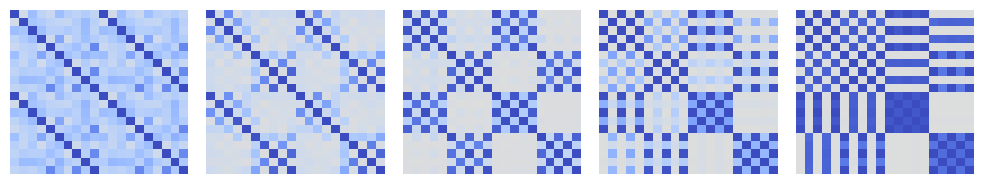

In [12]:
idx_seed = 0
seed = seeds[idx_seed]

indices = results_task_switching[seed]['indices']
state_dict = results_task_switching[seed]['model']

model = get_task_model(task_switching_tasks,
                       num_hidden,
                       idxs_contexts,
                       device)
model.load_state_dict(state_dict)

_, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

_, activations = hooks.get_layer_activations(model,
                                             tasks_testloader,
                                             criterion=criterion,
                                             device=device)

numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
numbers = numbers[indices['test']]

mean_activations = get_mean_activations(activations,
                                        num_hidden,
                                        list_labels=numbers,
                                        tasks_names=tasks_names)

sm_dict = calculate_sm(mean_activations,
                            tasks_names=tasks_names)

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_sm(ax, sm_dict, num_hidden)
fig.tight_layout()
plt.show()